<a href="https://colab.research.google.com/github/canon14/MovieRecommendationModel/blob/main/MovieRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
#Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import re
from scipy.stats import gaussian_kde

%matplotlib inline

In [2]:
# Create dataframes for all the files
# artist_attributes_df = pd.read_csv('/content/artist_attributes.csv')
# artist_to_imdb_df = pd.read_csv('/content/artist_to_imdb.csv')
# imdb_attributes_df = pd.read_csv('/content/imdb_attributes.csv')
# imdb_genres_df = pd.read_csv('/content/imdb_genres.csv')
# links_df = pd.read_csv('/content/links.csv')
# movie_genres_df = pd.read_csv('/content/movie_genres.csv')
# movie_title_keywords_df = pd.read_csv('/content/movie_title_keywords.csv')
# movies_df = pd.read_csv('/content/movies.csv')
tmdb_attributes_df = pd.read_csv('/content/tmdb_attributes.csv')
tmdb_genres_df = pd.read_csv('/content/tmdb_genres.csv')
tmdb_keywords_df = pd.read_csv('/content/tmdb_keywords.csv')
tmdb_overview_keywords_df = pd.read_csv('/content/tmdb_overview_keywords.csv')

In [ ]:
ratings_df = pd.read_csv('/content/ratings.csv')

In [ ]:
#Check total num of rows for each dataframe
df_names = [artist_attributes_df, artist_to_imdb_df, imdb_attributes_df, imdb_genres_df, links_df, movie_genres_df, movie_title_keywords_df, movies_df, ratings_df, tmdb_attributes_df, tmdb_keywords_df, tmdb_overview_keywords_df]
names = ['artist_attributes_df', 'artist_to_imdb_df', 'imdb_attributes_df', 'imdb_genres_df', 'links_df', 'movie_genres_df', 'movie_title_keywords_df', 'movies_df', 'ratings_df', 'tmdb_attributes_df', 'tmdb_keywords_df', 'tmdb_overview_keywords_df']

for i in range(0, len(df_names)):
  print(f'{names[i]} : {len(df_names[i])}')
  print(f'{names[i]} columns: {df_names[i].columns}')
  print('--------------------------------------------')


artist_attributes_df : 175719
artist_attributes_df columns: Index(['artist_id', 'name'], dtype='object')
--------------------------------------------
artist_to_imdb_df : 627212
artist_to_imdb_df columns: Index(['artist_id', 'imdb_id'], dtype='object')
--------------------------------------------
imdb_attributes_df : 14761
imdb_attributes_df columns: Index(['tid', 'title', 'url', 'imdbRating', 'duration', 'year', 'nrOfWins',
       'nrOfNominations'],
      dtype='object')
--------------------------------------------
imdb_genres_df : 33040
imdb_genres_df columns: Index(['genre', 'id'], dtype='object')
--------------------------------------------
links_df : 9742
links_df columns: Index(['imdbId', 'movieId', 'tmdbId'], dtype='object')
--------------------------------------------
movie_genres_df : 22084
movie_genres_df columns: Index(['Unnamed: 0', 'genre', 'movieID', 'title'], dtype='object')
--------------------------------------------
movie_title_keywords_df : 47663
movie_title_keywords

#**Data Exploration and Cleaning/Transformation**

###**Artist**

In [ ]:
#Artist 
artist_attributes_df.head()

,artist_id,name
0,nm0000001,Fred Astaire
1,nm0000002,Lauren Bacall
2,nm0000003,Brigitte Bardot
3,nm0000004,John Belushi
4,nm0000005,Ingmar Bergman


In [ ]:
artist_attributes_df.describe()

,artist_id,name
count,175719,175719
unique,175719,173131
top,nm0000001,Dinesh
freq,1,7


There are 175719 unique artists but only 173131 names..Some names might be duplicated in this dataset

In [ ]:
#Check for duplicate names
artist_attributes_df.value_counts('name')

name
Dinesh               7
Chris Brown          6
John Gilbert         5
Robert Hall          5
Chris Wright         5
                    ..
Gustavo Pizzi        1
Gustavo Pomeranec    1
Gustavo Rodriguez    1
Gustavo Ron          1
Þórir Waagfjörð      1
Length: 173131, dtype: int64

In [ ]:
#Should we remove these duplicates? The problem is these names also have unique artist_id, this means that different movies starred by these artists might be using different artist_id for the same artist
#It is safe to just keep them for now
artist_attributes_df[artist_attributes_df['name'] == 'Dinesh']

,artist_id,name
93166,nm10010521,Dinesh
158451,nm5110893,Dinesh
161717,nm5625923,Dinesh
166104,nm6549371,Dinesh
171504,nm8128125,Dinesh
171524,nm8135104,Dinesh
175206,nm9696209,Dinesh


###**IMDB**

In [ ]:
imdb_attributes_df = pd.read_csv('/content/imdb_attributes.csv')

In [ ]:
imdb_attributes_df.describe()

,tid,title,url,imdbRating,duration,year,nrOfWins,nrOfNominations
count,14761,14761,14761,13582,13730,14716,14760,14761
unique,14761,14717,14758,515,656,264,133,153
top,tt0012349,Der Mann\,der mann der zuviel wu te,7.3,1800,2011,0,0
freq,1,12,2,584,902,667,8317,9263


In [ ]:
imdb_attributes_df.head(10)

In [ ]:
imdb_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14761 entries, 0 to 14760
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tid              14761 non-null  object
 1   title            14761 non-null  object
 2   url              14761 non-null  object
 3   imdbRating       13582 non-null  object
 4   duration         13730 non-null  object
 5   year             14716 non-null  object
 6   nrOfWins         14760 non-null  object
 7   nrOfNominations  14761 non-null  object
dtypes: object(8)
memory usage: 922.7+ KB


In [ ]:
#Transform datatypes 
#We are using errors='coerce' in case if there is any junk data, meaning any data that is not its respective type.. it will be replaced by NaN/Null
def transform_numeric_datatypes(df, cols):
  for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def transform_int_datatypes(df, cols):
  for col in cols:
    df[col] = df[col].astype('Int64')

def transform_str_datatypes(df, cols):
  for col in cols:
    df[col] =  df[col].astype(str)

def transform_date_datatypes(df, cols):
  for col in cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

A lot of these values do not make sense (e.g. max year = 276637, max nrOfWins = 7620, etc). We will have to clean the data for further analysis. Let's investigate some of these columns.

In [ ]:
#Convert datatypes for columns
transform_numeric_datatypes(imdb_attributes_df, ['imdbRating', 'duration', 'year', 'nrOfWins', 'nrOfNominations'])
transform_str_datatypes(imdb_attributes_df, ['title'])

#drop rows where year is less than 1900 and more than 2022
imdb_attributes_df = imdb_attributes_df[(imdb_attributes_df['year'] > 1900) & (imdb_attributes_df['year'] < 2023)]

#drop rows where nrOfWins is more than 100 
imdb_attributes_df = imdb_attributes_df[imdb_attributes_df['nrOfWins'] <= 100]

# drop rows if not Movie, TV Series, TV Mini-Series, or TV Episode 
imdb_attributes_df = imdb_attributes_df[~imdb_attributes_df.title.str.contains('|'.join(['Video', 'Video Game']))]

#create a new column called 'category' to store title category
imdb_attributes_df['category'] = ""

#Parse strings to define title category
for index,data in enumerate(imdb_attributes_df['title']):
    if "TV Episode" in data:
      imdb_attributes_df['category'][index] = 'TV Episode'
    elif "TV Series" in data:
      imdb_attributes_df['category'][index] = 'TV Series'
    elif "TV Mini-Series" in data:
      imdb_attributes_df['category'][index] = 'TV Mini-Series'
    else:
      imdb_attributes_df['category'][index] = 'Movie'

#Split title to only keep the title (excluding title category and year released)
imdb_attributes_df['title'] = imdb_attributes_df['title'].apply(lambda x: x.split(' (')[0])

#Check average duration value for each category to fill duration missing value
imdb_attributes_df.groupby('category').mean('imdbRating')
imdb_attributes_df['duration'] = imdb_attributes_df['duration'].fillna(round(imdb_attributes_df['duration'].mean()))

#Drop rows where imdbRating is NULL since these are mostly episodes of TV Episode/Series/Mini-Series
imdb_attributes_df = imdb_attributes_df[imdb_attributes_df['imdbRating'].notnull()]

#transform datatypes final
transform_int_datatypes(imdb_attributes_df, ['duration', 'year', 'nrOfWins', 'nrOfNominations'])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to b

In [ ]:
#Check the cleaned and transformed datasets
imdb_attributes_df.head()

,tid,title,url,imdbRating,duration,year,nrOfWins,nrOfNominations,category
0,tt0012349,Der Vagabund und das Kind,http://www.imdb.com/title/tt0012349/,8.4,3240,1921,1,0,Movie
1,tt0015864,Goldrausch,http://www.imdb.com/title/tt0015864/,8.3,5700,1925,2,1,Movie
2,tt0017136,Metropolis,http://www.imdb.com/title/tt0017136/,8.4,9180,1927,3,4,Movie
3,tt0017925,Der General,http://www.imdb.com/title/tt0017925/,8.3,6420,1926,1,1,Movie
4,tt0021749,Lichter der Gro√üstadt,http://www.imdb.com/title/tt0021749/,8.7,5220,1931,2,0,Movie


In [ ]:
imdb_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12594 entries, 0 to 14760
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tid              12594 non-null  object 
 1   title            12594 non-null  object 
 2   url              12594 non-null  object 
 3   imdbRating       12594 non-null  float64
 4   duration         12594 non-null  Int64  
 5   year             12594 non-null  Int64  
 6   nrOfWins         12594 non-null  Int64  
 7   nrOfNominations  12594 non-null  Int64  
 8   category         12594 non-null  object 
dtypes: Int64(4), float64(1), object(4)
memory usage: 1.0+ MB


In [ ]:
imdb_attributes_df.describe()

,imdbRating,duration,year,nrOfWins,nrOfNominations
count,12594.000000,12594.000000,12594.000000,12594.000000,12594.000000
mean,6.871074,5677.377402,1989.056535,3.312609,4.832778
std,1.105552,2605.833835,22.455765,8.144872,13.897070
min,1.000000,60.000000,1902.000000,0.000000,0.000000
25%,6.300000,4980.000000,1977.000000,0.000000,0.000000
50%,7.000000,5760.000000,1997.000000,0.000000,0.000000
75%,7.600000,6660.000000,2006.000000,3.000000,4.000000
max,9.900000,68400.000000,2014.000000,94.000000,418.000000


In [ ]:
# imdb_attributes_df.to_csv('imdb_attributes_cleaned.csv', index = False)

#**TMDB**

In [82]:
tmdb_attributes_df = pd.read_csv('/content/tmdb_attributes.csv')
tmdb_genres_df = pd.read_csv('/content/tmdb_genres.csv')
tmdb_keywords_df = pd.read_csv('/content/tmdb_keywords.csv')
tmdb_overview_keywords_df = pd.read_csv('/content/tmdb_overview_keywords.csv')

In [83]:
tmdb_genres_df.head()

,Unnamed: 0,genre,movieID,title
0,0,Action,19995,Avatar
1,1,Adventure,19995,Avatar
2,2,Fantasy,19995,Avatar
3,3,SciFi,19995,Avatar
4,4,Adventure,285,Pirates of the Caribbean: At World's End


##Data Cleaning and Transformation

In [84]:
#Create separate dataframes to group genres (genre count and lists)
#Genre Count
genre_count_df = tmdb_genres_df.groupby(['title', 'movieID'],as_index=False).count().rename(columns={'genre' : 'genre_counts'})
genre_count_df = genre_count_df.drop('Unnamed: 0', axis=1)

#Group Genre into lists 
genre_lists_df = tmdb_genres_df.groupby(['title', 'movieID'])['genre'].apply(list).reset_index(name='genres')

In [85]:
#Join all the created dataframes into tmdb_attributes
genre_count_lists_df = genre_lists_df.merge(genre_count_df, how='inner', on=['title', 'movieID'])

tmdb_attributes_df = tmdb_attributes_df.merge(genre_count_lists_df, how='inner', left_on='id', right_on='movieID')

#rename and drop columns
tmdb_attributes_df = tmdb_attributes_df.drop(['title_x', 'title_y', 'movieID'], axis=1).rename(columns={'id': 'movie_id', 'original_title':'title'})

In [89]:
tmdb_attributes_df

,budget,movie_id,original_language,title,popularity,release_date,revenue,runtime,tagline,vote_average,vote_count,genres,genre_counts
0,237000000,19995,en,Avatar,150.437577,12/10/09,2787965087,162.0,Enter the World of Pandora.,7.2,11800,"[Action, Adventure, Fantasy, SciFi]",4
1,300000000,285,en,Pirates of the Caribbean: At World's End,139.082615,5/19/07,961000000,169.0,"At the end of the world, the adventure begins.",6.9,4500,"[Adventure, Fantasy, Action]",3
2,245000000,206647,en,Spectre,107.376788,10/26/15,880674609,148.0,A Plan No One Escapes,6.3,4466,"[Action, Adventure, Crime]",3
3,250000000,49026,en,The Dark Knight Rises,112.312950,7/16/12,1084939099,165.0,The Legend Ends,7.6,9106,"[Action, Crime, Drama, Thriller]",4
4,260000000,49529,en,John Carter,43.926995,3/7/12,284139100,132.0,"Lost in our world, found in another.",6.1,2124,"[Action, Adventure, SciFi]",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4770,0,67238,en,Cavite,0.022173,3/12/05,0,80.0,NaN,7.5,2,"[Foreign, Thriller]",2
4771,220000,9367,es,El Mariachi,14.269792,9/4/92,2040920,81.0,"He didn't come looking for trouble, but troubl...",6.6,238,"[Action, Crime, Thriller]",3
4772,9000,72766,en,Newlyweds,0.642552,12/26/11,0,85.0,A newlywed couple's honeymoon is upended by th...,5.9,5,"[Comedy, Romance]",2
4773,0,231617,en,"Signed, Sealed, Delivered",1.444476,10/13/13,0,120.0,NaN,7.0,6,"[Comedy, Drama, Romance, TV Movie]",4


In [90]:
tmdb_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4775 entries, 0 to 4774
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   budget             4775 non-null   int64  
 1   movie_id           4775 non-null   int64  
 2   original_language  4775 non-null   object 
 3   title              4775 non-null   object 
 4   popularity         4775 non-null   float64
 5   release_date       4775 non-null   object 
 6   revenue            4775 non-null   int64  
 7   runtime            4773 non-null   float64
 8   tagline            3956 non-null   object 
 9   vote_average       4775 non-null   float64
 10  vote_count         4775 non-null   int64  
 11  genres             4775 non-null   object 
 12  genre_counts       4775 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 522.3+ KB


In [91]:
#Generate the summary statistics for the data
tmdb_attributes_df.describe()

,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count,genre_counts
count,4.775000e+03,4775.000000,4775.000000,4.775000e+03,4773.000000,4775.000000,4775.000000,4775.000000
mean,2.921458e+07,55988.208796,21.617344,8.274265e+07,107.207207,6.114199,694.257382,2.546597
std,4.078120e+07,87310.177303,31.867749,1.632119e+08,21.960616,1.140636,1237.070089,1.107292
min,0.000000e+00,5.000000,0.000372,0.000000e+00,0.000000,0.000000,0.000000,1.000000
25%,9.500000e+05,8998.500000,4.806600,0.000000e+00,94.000000,5.600000,55.000000,2.000000
50%,1.500000e+07,14536.000000,13.119133,1.947206e+07,104.000000,6.200000,238.000000,2.000000
75%,4.000000e+07,57206.500000,28.499077,9.357130e+07,118.000000,6.800000,742.000000,3.000000
max,3.800000e+08,459488.000000,875.581305,2.787965e+09,338.000000,10.000000,13752.000000,7.000000


In [96]:
# Generate the correlation between different features in the data
tmdb_attributes_df.corr()

,budget,movie_id,popularity,revenue,runtime,vote_average,vote_count,genre_counts
budget,1.000000,-0.081545,0.504032,0.730347,0.268272,0.084173,0.592273,0.264131
movie_id,-0.081545,1.000000,0.040926,-0.044576,-0.120228,-0.243504,0.003348,-0.136362
popularity,0.504032,0.040926,1.000000,0.644069,0.222995,0.275098,0.777671,0.148471
revenue,0.730347,-0.044576,0.644069,1.000000,0.251838,0.197448,0.781132,0.178318
runtime,0.268272,-0.120228,0.222995,0.251838,1.000000,0.348373,0.272625,0.068333
vote_average,0.084173,-0.243504,0.275098,0.197448,0.348373,1.000000,0.318236,0.046842
vote_count,0.592273,0.003348,0.777671,0.781132,0.272625,0.318236,1.000000,0.148988
genre_counts,0.264131,-0.136362,0.148471,0.178318,0.068333,0.046842,0.148988,1.000000


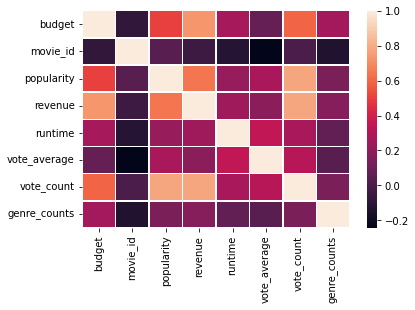

In [100]:
#Visualize the correlation between features
corr = tmdb_attributes_df.corr()
sns.heatmap(corr, linewidths=.5)

##Data Visualization

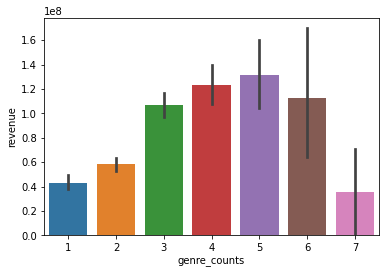

In [104]:
#Does more genres have any effect on revenue?

sns.barplot(data=tmdb_attributes_df, x='genre_counts', y='revenue')

It seems that the more genres a movie has, the more revenue it is generating. This is true up until 5 genres, after that, revenue starts to decline. This may be caused by confusion by watchers as what exactly is the genre of the movie they are watching.

In [ ]:
#What is the most favorite genre/ genre combination?

